In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
# from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer
# from nltk.stem import WordNetLemmatizer
import re  
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


import nltk
import ssl
 
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stops = set(stopwords.words("english"))


import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nipunas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
def clean_text(text, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = text.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    cleaned_text = " ".join(words)

    # Clean the text
    cleaned_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", cleaned_text)
    cleaned_text = re.sub(r"\'s", " 's ", cleaned_text)
    cleaned_text = re.sub(r"\'ve", " 've ", cleaned_text)
    cleaned_text = re.sub(r"n\'t", " 't ", cleaned_text)
    cleaned_text = re.sub(r"\'re", " 're ", cleaned_text)
    cleaned_text = re.sub(r"\'d", " 'd ", cleaned_text)
    cleaned_text = re.sub(r"\'ll", " 'll ", cleaned_text)
    cleaned_text = re.sub(r",", " ", cleaned_text)
    cleaned_text = re.sub(r"\.", " ", cleaned_text)
    cleaned_text = re.sub(r"!", " ", cleaned_text)
    cleaned_text = re.sub(r"\(", " ( ", cleaned_text)
    cleaned_text = re.sub(r"\)", " ) ", cleaned_text)
    cleaned_text = re.sub(r"\?", " ", cleaned_text)
    cleaned_text = re.sub(r"\s{2,}", " ", cleaned_text)
    
    words = re.split('\W+', cleaned_text)                        # remove all non-words (make a list)
#     words = cleaned_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    
    cleaned_text = " ".join(stemmed_words)
    
    # Return cleaned text 
    return(cleaned_text)


In [24]:
#Input: corpus is a list of dictionaries(with all fields and data) 
def extract_clean_documents_from_corpus(corpus):
    print("Extracting and Cleaning documents...")
    final_corpus = []
    list_of_docs = []
    ticket_ids = []
    i = 0
    for ticket_dict in corpus:
        print("Processing ",ticket_dict['summary'])
        doc_cleaned_text = ''
        document_of_words = (str(ticket_dict['summary'])+" "+str(ticket_dict['description']))
#         document_of_words = (str(ticket_dict['question1']))
        doc_cleaned_text = clean_text(document_of_words)
        list_of_docs.append(doc_cleaned_text)
#        final_corpus.append({'key':ticket_dict['key'],'index':i})
        final_corpus.append({'key':ticket_dict['key'],'index':i})
#         final_corpus.append({'qid1':ticket_dict['qid1'], 'words':doc_cleaned_text, 'index':i})
        ticket_ids.append(ticket_dict['key'])
        i+=1
    return list_of_docs,final_corpus, ticket_ids

In [4]:
#save and load moddel
def save_model(model,model_name):
    pickle.dump(model, open(model_name, "wb"))

def load_model(model_file_path):
    with open(model_file_path, 'rb') as pickled_file:
        loaded_model_data = pickle.load(pickled_file)
    return loaded_model_data


def find_top_n_similar_documents(n,tfidf_test,tfidf_trainingset,cleaned_training_corpus):
   cosine_similarities = linear_kernel(tfidf_test, tfidf_trainingset).flatten()
   related_docs_indices = cosine_similarities.argsort()[:-n:-1]
   related_jira_ids = []
   for ticket in cleaned_training_corpus:
       if(ticket['index'] in related_docs_indices):
           related_jira_ids.append(ticket['key'])
            #  related_jira_ids.append(ticket['qid1'])
   return related_docs_indices,related_jira_ids



In [5]:
model_name = "first_draft_1"

df = pd.read_csv(model_name+'.csv')
print(df.head(10))
# Create corpus from data frame
corpus = df.to_dict('records')

                key     l1                   l2                        l3  \
0  P10049895-100023  Verdi      C/SystemC Debug  Interactive debug / CBug   
1  P10049895-100024  Verdi    Interactive Debug                       VCS   
2  P10049895-100237  Verdi       Coverage Debug                  Coverage   
3  P10049895-100313  Verdi               Dumper                       VCS   
4  P10049895-100316  Verdi            Testbench                 SVTB Core   
5  P10049895-100373  Verdi            Licensing                       NaN   
6  P10049895-100401  Verdi  Compiler (UFE flow)                    vlogan   
7  P10049895-100594  Verdi                  VIA                FSDB Model   
8  P10049895-100635  Verdi      Low Power Debug                       NaN   
9  P10049895-100691  Verdi                nWave                       NaN   

    l4                                            summary  \
0  NaN         Crash in interactive mode with Verilog PLI   
1  NaN                 Verdi S

In [11]:
print(type(corpus))

<class 'list'>


In [25]:
# extract_clean_documents_from_corpus
list_of_docs,training_ticket_corpus, til = extract_clean_documents_from_corpus(corpus)

Extracting and Cleaning documents...
Processing  Crash in interactive mode with Verilog PLI
Processing  Verdi Slow in UVM Interactive mode
Processing  Intel: GT  Incorrect assertion coverage information
Processing  [Qualcomm Austin] Verdi interactive does not seem
Processing  INTEL : Trace deriver not working for interface signals in Verdi
Processing  [SMARTi6 AMS] Seg. fault due to none existing License
Processing  INTEL ICL: Warning-[CHRIGN] Characters after option ignored  Characters '-kdb'
Processing  ‘ffrCreateTimeBasedVCTrvsHdl’ segfault on SVLF ‘.vf’ file - NPI replacement
Processing  Verdi reports an error for set_supply_set_state
Processing  Verdi does not plot MFR port
Processing  Unified compile memory blowup with 2014.12
Processing  Can't trace drivers through streaming operator
Processing  Intel: Not able to restore the session with Signal list pane in power debug mode
Processing  Verdi: covergroup instance bin -> planner incorrect "group bin"
Processing  Verdi fatal error

Processing  NVIDIA: Verdi fsdb2vcd crash
Processing  Verdi integration: The Incr. Sch. does not show full name of clock/domain on net
Processing  customized toolbar item not visible after restart
Processing  Intel CDS - Color confusion for inactive region of code due to compilation.
Processing  Unable to generate urg report with Verdi when using 64 bit binaries
Processing  Verdi fsdbextract crash
Processing  Request for Verdi to start-up in background
Processing  Intel ATP2- [Error-VFS_SDB_SYNC]  with VCS 2016.06 while Verdi is open
Processing  Intel GT- Change to Primary on the nWave menu is disabled in interactive run
Processing  Intel scntinel- GUI passed register path name but didn't include generate label
Processing  [Napali PA GLS] FSDB run terminates abruptly
Processing  [SIMBug][IUS]vpi_iterate(vpiPort  module_handle) causes a crash
Processing  Verdi interactive debug crash
Processing  Verdi-Cov: Annotation Too Few Characters in Drop D
Processing  Verdi hangs while loading sign

Processing  System Verilog compilation error (and crash)
Processing  vericom -synthesis_directives issue
Processing  Pack novas2011.01 with updated license daemon
Processing  2011.01 RealIntent OEM build
Processing  [M:SPS0225182] -sv versus +systemverilogext+.sv
Processing  Rule 23003 Inferred Latch in case statement is strange
Processing  Trace Driver problem
Processing  [M:SPS0228247] Install Linux 5.6 on spx130
Processing  Siloti hang question
Processing  [Interface] Reloading primary fsdb file takes much longer time.
Processing  Siloti 2010.07 dumper running much slower than 2009.04 of the same design
Processing  [nClock][Domain] Have a crash when extract clock domain
Processing  Macro syntax error from 2011.01 but works fine in 2010.07
Processing  Verdi hangs loading design
Processing  NF for signals connected to logic 1
Processing  vericom performance issue on 2011.04CF version
Processing  FSDB_API: Fixes for load gzipped fsdb
Processing  FSDB reader with gzip file produces *WAR

Processing  verdi not follwing NOVAS_MANAGE_RC_DIR
Processing  [Verdi3 2013.01][vericom] vericom hangs during compile
Processing  verdi crashes loading a netlist file
Processing  [Verdi3 2013.01] Compile error with 2013.01 that do not happen with 2012.07p4
Processing  [M:SPS0306995] neco output icc script needs library info
Processing  [M:SPS0306995] icc script output incorrect  uses -empty switch
Processing  [M:SPS0306995] connect_net from concate net to bus pin
Processing  [M:SPS0306995] needs disconnect_net before connect_net
Processing  [M:SPS0306995] need create_net before connect_net when multi eco
Processing  [M:SPS0306995] need create_port before connect_net when multi ecos
Processing  [M:SPS0306995] eliminate top design name from the hierarchy path
Processing  Enhance parser to handle parameter with time scale
Processing  [M:SPS0245375] [CTS] Remove env NOVAS_CLOCK_COVERAGE which control covergage rep
Processing  [Verdi3]Failed to recognize the identifiers from VCS rvm
Process

Processing  Verdi Crash with connectivity tracing
Processing  Unable to open the traces after hitting Ctrl+C to stop a 'check_fv -block' run
Processing  Verdi instance view lacks generated modules
Processing  verdi load hangs
Processing  Unable to drag and drop object in nWave
Processing  TI AM64 -- Tarmac namespace collision when M3 and M4 in the same emulation project
Processing  TI J7VCL: M3 Emulation Tarmac outputs time does not align with emulation wave time or other tarmac file time entries
Processing  vericom - crash (signal 11)
Processing  VCAPP "vatbox_list_mda" is hanging
Processing  Verdi  failure with "The KDB has been deleted by other processes"
Processing  [Intel-MIG-DTC] Verdi crash while loading design with UPF
Processing  [TBRCA][OVM lib]- OVM transaction dumping print extra errors 
Processing  [Intel-IPSG-ICD] Crash with nCompare in P-2019.06-SP2-2 which points to QAlphaPa
Processing  QCOM : LAHAINA: kdb_postelab.csh is hung for 24+ hour.
Processing  Connection to Ver

Processing  Onesearch doesn't work for soft linked KDB
Processing  NVIDIA [DFT] | CT Crash with -kdb on gate level design
Processing  Instruction WFI is not recognized
Processing  vlogan stuck for a long time with -kdb switch
Processing  Axis -Verdi with vmm+SysC issue
Processing  slow performance of ChipInt
Processing  Verdi is slow with large exclude file compared to DVE
Processing  VCS crash on absdelta testcase
Processing  Verdi Performance Bad in 2019.06-SP1-1
Processing  Migration only - slow performance of ChipInt
Processing  AMAZON: elab crash during dump adrt
Processing  Verdi crashes when loading waveforms while the simulation is running
Processing  Verdi Crash Segmentation fault when (EMAN -> Coverage mode/open cov)
Processing  Qualcomm low-power signal shading issue
Processing  Some signals are not found in the FSDB
Processing  Verdi hangs while running Syn2SymDB utility
Processing  FSDB reader message callback functions are not called
Processing  [INTEL-VTT-MTL] Verdi Cras

Processing  Intel-[C2DG-RWC] Vericom crash with 2017.12-SP2-14
Processing  [SD-MODEM]Exclude connected signals on a port of type struct 
Processing  AMAZON: random parse time crash  KdbWriter::genKdbCommon  with -kdb=common_elab
Processing  [MTK] "verdi -lib" has Error but "verdi -dbdir" hasn't
Processing  Warnings on converting ARM CR4 tarmac
Processing  Stellar - Spice cells not seen in Verdi AMS
Processing  vericom cunit overwritting global package
Processing  VC SpyGlass not creating schematics
Processing  QCOM: Driver tracing of signal fails
Processing  [Intel-GNR] Certain Bind'd interface wrappers are not seen in verdi
Processing  #NAME?
Processing  Apple: Wrong parameter value in KDB
Processing  QCOM :: Performance issue in tracking properties  fsdb waveform viewer.
Processing  Verdi crash 
Processing  AMD: Verdi crash for a SEQ setup
Processing  RE: Vericom Crashing with -cunit
Processing  [Intel-PDG-LNC] Verdi crash during VCS simulation
Processing  Nothing in Verdi GUI
Proces

Processing  Apple: Issue tracing through interface instance arrays
Processing  verdi/2020.12 crash
Processing  VCS report LZMA and crash with version  2020.03-SP1-1and2020.12-1
Processing  [Intel-SIP-PCIE] Not able to view spec (in pdf) in verdi coverage
Processing  [Intel-ICG-HKR] : fsdb2saif issues due to fsdb hierarchy
Processing  Cell File information not always available in property table in schematic
Processing  QCOM Markham: Hang during elabcom with vcs 2020.12-SP1
Processing  UVM error indicator is located at the wrong time
Processing  Verdi is not showing the right library for specific module
Processing  NVIDIA| Tegra DFT|Discrepency btw VCS and Verdi (GUI) for DW part when using -y with  fv compatible module
Processing  Intel GNR: Elab crash with -kdb=postelab
Processing  QCOM : : No highlight in verdi gui driver trace
Processing  [GNR] Verdi picked a wrong module than Zebu
Processing  Can't get interface instance name from modport
Processing  AMD Markham: VC formal 2020.12 n

Processing  [Intel-PCH-LNL] Elaboration time increased due to "KDB-ELAB-FLV2O" warning in VEGA2 flow
Processing  Apple: vericom/elabcom generating errors on valid SV macro code
Processing  Failed to open the file(XXX.fsdb.frdlist) with Z01X
Processing  crash when database is closed
Processing  [INTEL]: Verdi Not working
Processing  Unable to open KDB in verdi with 2020.12 version
Processing  Can't dump waves with encrypted RTL
Processing  Connection is broken on interface array 
Processing  [Intel-PDG] Verdi shows wrong parameter value when using "-G"
Processing  Opening GLS results with Verdi post-processing mode takes too long time
Processing  QCOM - Verdi Coverage hang
Processing  GroupCount column width explodes to width of Activity view when sorting on another column
Processing  Crash when checking crossing domain with a RTL design.
Processing  [ChipInt] Bug is found at range of port declaration
Processing  SV Variables of an include file not showing up in Local Pane of Verdi Inte

Processing  Cirrus: Branch coverage not correctly reported on ARM M4F cores (Toots)
Processing  Apple: macho2elf doesn't support LLVM 6.0.0
Processing  [Intel-PDG-LNC] Filtering columns that contain large numbers does not work properly
Processing  [SARC] Signals show wrong computed values in Verdi when used with ucli forces
Processing  Unable to exclude connected signals inside an interface
Processing  VC Apps/HierMan  Generated FM mapping file issue
Processing  GN verdi hang from instance window
Processing  [LNL] Verdi-NPI - The npiFsdbSigIsPacked does not return right value when working with SLVF
Processing  verdi coverage gui shows assertion not covered in source window which is not correct
Processing  Facebook: mismatch between VCS elaboration and Verdi
Processing  Missing Assertion Module in Verdi instance Instance pane
Processing  pa_begin/pa_end markers are set at the wrong times
Processing  [Intel-IL-C2DG] Eventually failure followed by a stack trace
Processing  Nvidia: GPU una

Processing  Intel GT - scfeclt vcs kdb error on vcs/verdi 2016
Processing  [SKYRUNNER]:Interactive simulation  terminates when synopsys_sim.setup not found
Processing  [SKYRUNNER] : VHDL signals names not visible in hierarchical flatten schematic v
Processing  Intel HSD-[1179993]Verdi: QA: TSI: Getting ELab error from v
Processing  Intel Monette Hill:  Stack trace when using "+UVM_VERDI_TRACE"
Processing  [Intel] [10nm IIO] 2016.06 QA Error with Verdi 2016.06 unbound user defined type
Processing  [Avago] Wave counter doesn’t work once checkpoint is issued
Processing  Oracle: relative bind paths not supported inside generates
Processing  Oracle: Verdi UFE error when port order doesn't match
Processing  Intel HSD-elabcom error:failed to find identifier when declared parm and macro
Processing  Intel Altera-Verdi takes 4+ hrs for design resolution but VCS takes 2 hours
Processing  Intel 10nm-Verdi not matching VCS libraries
Processing  Intel 10nm- elabcom error: failed to find identifier m

Processing  [Nokia MADE] CC: view_schematic -cc_prop make Verdi die
Processing  Tegra: Wrong values shown in Verdi for parameters in generate block
Processing  Performance issue about fsdb at 2017.03-SP1
Processing  VHDL parameter annotation fails for value calculated by function
Processing  AMAZON:  the file "./../common/uvm_ml_config_rsrc.h" does not exist
Processing  AMAZON: fsdb crash during traversal
Processing  Verdi annotates  correct  assertion values only with fsdb+delta
Processing  [Intel-CIG-ICP] FSDB dump getting corrupted
Processing  selecting anywhere under marker label moves marker
Processing  verdi crashed while running VC app listRegisters_batch.tcl
Processing  Intel-PDG-ICL: fsdbextract crashes with assert FHRFn::FNTYPE_PartGate != fnData
Processing  AMAZON: OneSearch to support searching  user C code given as .so
Processing  APPLE: Verdi bacom shang with 2016.06-SP2
Processing  [Intel-SDG-icxsp] Verdi scope search does not handle whitespace properly
Processing  Intel

Processing  nan
Processing  Digital signals do not get plotted in waveform window
Processing  [Intel-iCDG-MPHY]   Zoom value is not reloaded  from rc file
Processing  Cannot add streams to protocol analyzer after restart
Processing  Multiple Verdi crashes
Processing  NVidia | Memory Consumption Issue Using 2017.03 and -kdb
Processing  AMAZON UCLI  fsdbAutoSwitchDumpfile crashes if no arugment is given
Processing  Verdi: No error msg poped up when view_schematic -instance fails
Processing  QCOM: PoP issue in using -verdi option
Processing  [Intel CDG ADL] VCLP waiver - append to file from GUI is not working
Processing  [Intel-Atom-Gracemont] named block missing from hierarchy browser
Processing  [TNPA] TCL commands to handle Transaction and Protocol Analyzer window
Processing  Verdi source code viewer hang while trying to open schematic
Processing  [Intel-SDG-chassis] fsdbdebug crash when running fsdbprof
Processing  [INTEL-VPG-GEN12] Verdi Hanging when Excluding tgl
Processing  fsdb du

Processing  fsdb2saif is not escaping instances that start with a number
Processing  Questions on Verdi^3 support for OSCI SystemC
Processing  Verdi^3 is crashing(user's env. problem)
Processing  Add file novas.conf into sysinfo.tar
Processing  [nSoft] step and next do not work on the last cycle (at the end of simulation)
Processing  [M:SPS0272543] vericom hit the file system limit
Processing  fsdb2vcd crash
Processing  fsdb2vcd doesn't convert record type
Processing  F case1: change scopes performance
Processing  F case 3: filter takes too long
Processing  F case4: search a string in side a scope takes a long time
Processing  F case5: create signal view takes long time
Processing  F case6: signal view generates many error messages
Processing  20G fsdb will cost 200G memory on nWave debug
Processing  load design error
Processing  F case8: crash at  ulString::append () when find string
Processing  Verdi^3 and nWave check back idle issue
Processing  coredump which check convergence node 

Processing  [Verdi-AMS] nSchema shoud show “nmos” or “pmos” in schematic
Processing  SARC VERDI 2015.09-SP1-1 CRASH when searching for a file
Processing  SARC: Compile crash on GLS design with sdf
Processing  [Intel SMARTi  Linz]  Interactive Element of type real not shown as analog wave
Processing  .vf file with FSDB files for different cycles not displaying signal values
Processing  Verdi Driver Tracing Performance/Hang on Gate Design
Processing  Verdi gets hanged when compiling the design
Processing  Verdi Tracing Capabilities break after canceling a long driver trace
Processing  ST MCD: unable to access sverilog code source in Verdi
Processing  Zebu  iCSA verdi gui signal window is not accessible
Processing  [CAE][VC Apps][DM] missing `endif with npi_dm_add_port
Processing  [SMARTi6 AMS] Seg. fault due to none existing License
Processing  Verdi doesnt merge across scopes
Processing  Intel COE75 : HSIO :: Verdi LP debug :: Issue with resolving parallel
Processing  MTK : Adding  sign

Processing  signals are invisible in Verdi local pane when thread going into fork/join
Processing  VCS AMS:dumper ignores unified dump “-depth 2” option
Processing  nWave displays wrongly in ASCII format
Processing  [nSchema][VC Apps] Crash in symiCreatePortDB() at Broadcom Bunnik
Processing  SARC: fsdbrecover doesn't support Native ESD FSDB
Processing  SARC: Verdi Interactive -- Simulator is terminated.
Processing  Logical operation on signals can't append new ones
Processing  [ICLGT]: npiFsdbUint64Val type does not seem to work correctly
Processing  [MTK]KDB Load Error while loading work.lib++ for coverage exclusions
Processing  Intel CNL"ERROR:Open name from work library failed" -in hybrid mode of VCS/Verdi
Processing  {QCOM-RTP:Firetail} Verdi Error with SVA dump in 2016.06
Processing  [ICLGT]: fsdb2saif output with vf file input is not compatible with ICC
Processing  {QCOM-RTP:Falkor} Verdi interactive issue ucli restart; run commands
Processing  “vc_activity” and “vc_static_shell

Processing  [Verdi]Default radix does not apply for SystemC model
Processing  QCOMM-BDC: crash while fsdb
Processing  Verdi Coverage incorrectly colorizing/marking "Excluded and Covered"
Processing  [Intel-CSG-WCS] Verdi 'bacom' command hangs while generating BDB database
Processing  [Performance Issue] Open power state table takes 10 minutes
Processing  [NOKIA] possibility to save checkpoints in Verdi
Processing  [Auto] Crash while tracing the source code in nTrace window
Processing  Intel-VPG-GEN12: Verdi quitting pop-up window does not accept "Yes" or "Cancel"
Processing  [verdi] warning: ” FHDB does not contain any data” and signals' vaule is NF
Processing  {QCOM-RTP:MDDR}R2R issue:Verdi Planner with coverage does not show coverage deta
Processing  Intel SDG-KNH: failed to find identifer during elabcom
Processing  Generate blocks are not visible in Verdi static window
Processing  [NOKIA MADE] Verdi UVM debug uvm_reg hanging on top level design
Processing  [Intel-PSG-Nadder]Verdi ha

Processing  [Intel-SDG-clockgen]: Verdi not executing and highlighting the UPF lines
Processing  [Intel-SDG-clockgen]: Verdi PowerDomain tree is showing incorrect PD scopes
Processing  Qcom-RTP:CoreIP L3 - Verdi Coverage challenges with 2017.03-SP1-1 and newer
Processing  {QCOM-Markham-LPASS} Elaboration memory blowup issue with elabcom
Processing  Inconsistency src viewer look and feel
Processing  [INTEL-VPG-GT] - Verdi crash on post-process mode
Processing  PAVE checkers not viewable in Verdi
Processing  Verdi loads old database (with -kdb) though latest compile is without -kdb
Processing  Qcom-RTP:CoreIP L3 - Verdi Cov Condition challenges with 2017.03-SP1-1 and newer
Processing  QCOM: Vlogan crashes with KDB enabled
Processing  [Intel-iCDG-MPHY]   incorrect annotation constant values for std_logic conversio
Processing  [Intel-CIG-TGPLP] Issues dumping out signals in waveform
Processing  Changing default “Auto” to “Left” in View options the alignment is not changing
Processing  Redu

Processing  {QCOM-RTP:Firetail} FSDBextract Performance issue
Processing  Can't view power data in wave or signal list windows
Processing  vcs for zebu hangs at elab stage
Processing  [Intel-CIG-TGPLP] KDB Warnings
Processing  Please increase the limit argument of $fsdbAutoSwitchDumpfile to more than
Processing  [Nokia]: Ctrl-F not functioning in instance window
Processing  [MTK] ENABLE_PERMISSION_CHECK doesn't work (source code displayed unexpectedly)
Processing  npiXRectify is not writing out rectified output correctly for included file
Processing  [MARVELL]- Invalid "port size differ" warning in UFE flow  wrong param override
Processing  [Intel-SDG-fivr] Trace driver lists assertions as drivers
Processing  [Intel-SDG-all] auto save signal file not saving automatically
Processing  [VCF] Incorrect failure at reset phase with VC-Formal
Processing  cannot add the clocking block signal to the waveform
Processing  AMAZON: show_scope is not listing all instances of module that was bind
Pro

Processing  INTEL-VPG-GT: Standalone CRDB utility crash
Processing  [Intel-iCDG-XG7660] RTL coverage - Verdi  -question
Processing  Verdi elab fails in UFE flow with certain way of package imports - VCS sim works
Processing  KDB generation gives either crash or memory corruption.
Processing  fsdbextract extracting extra hierarchies not specified
Processing  [Intel DCG]VCS KDB elab error pointing to cross coverpoint with kdb enabled
Processing  AMAZON:  cbug::invokeElabcom takes over 1 000 seconds and is not incremental
Processing  Verdi-NPI Issue : npi_handle_by_name( )
Processing  Filter by value should include NULL
Processing  Verdi Memory PA Debug  and memory traversal with peek/pokes at same time
Processing  Oscar: elabcom adds libpng12.so.1 library needlessly.
Processing  Oscar: VCS crashes in KdbMapping::~KdbMapping
Processing  Verdi Used wrong Parameter Value for elaboration
Processing  AMAZON: Verdi presents power state of parent module for bind module
Processing  [Intel-iCDG-P

Processing  {QCOM-RTP:Firetail}Verdi hierarchy pane displaying incorrect module
Processing  [Intel TGL-GLE] Verdi KDB elaboration fails with "floating point exception" err
Processing  INVIA: Verdi Hang when undocking nWaves
Processing  [Profichip] simv hangs inside pli_dhier_begin_event function with seg-fault
Processing  [Intel-TPD-SBFT]- fsdbreport failed to find signal
Processing  Verdi crashed while parsing design
Processing  verdi show warning when import pt report and set false path
Processing  emulation timeout
Processing  Notifier setup not functional
Processing  [VIA] Failed to get handle by name for some kind of signals
Processing  covergroup mapping to planner issue in 17.12
Processing  [Intel-iCDG-Smarti9] Verdi performance on start up  in comparison to DVE
Processing  [Intel-DDG-TGL] Verdi core dump on glitch tracing
Processing  AMD Markham: toggle half transition of -node 0to1 not working as expected
Processing  [Intel-SDG-csa] bind missing when display in Verdi
Processin

Processing  [Intel-PDS] "/tmp/fsdbgate.mtlog" location cannot be modified withTURBO_LOG_DIR
Processing  [Intel-MSV_CML] AMS simulation with VCS2017.12 fails on merged FSDB creation
Processing  [Intel-PCH-TGP] Functions not available in Verdi interactive using C/C++ .so
Processing  [Intel-PDC-ICL] Issues when clicking on a file path hyper link in Low Power Debg
Processing  VCS AMS:NXP:UNL:problems dumping digital signals Verilog-AMS(UNL)
Processing  VCS AMS:NXP:problems with plot/save signals with "!" suffix
Processing  [INTEL-VPG-GT] - Verdi exploding in memory
Processing  SPR 4D: Verdi seg fault while searching signal in signal List
Processing  [Intel-PDG-ADL] - elaboration hang with kdb
Processing  [Intel-iCDG-DCDC]  Verdi fails to show \work hierarchy  w same entity name
Processing  Verdi terminated abnormal frequently when adding waves
Processing  Intel-PDS : npiFsdbPowerSigType is not working  for power supply signals
Processing  [Intel-PSG-MAP200T]Verdi fails to show generate hie

Processing  [INTEL-GEN12HP-GT] Multi-tile module signal port s
Processing  stopping check_fv -block causes tool crash
Processing  verdi not dumping parametrized uvm agent while dve dumping ok
Processing  Failed to load the FSDB file/signals
Processing  [SpecLink] Link wrong location
Processing  [VCF-GUI] Unable to type letter 'r' in VCF console
Processing  Nvidia:NVLink: Tool Crashes when loading exclusion files in particular order
Processing  Nvidia:NVLink: Some valid exclusions dropped when using –excl_bypass_checks
Processing  Nvidia:NVLink:Slow GUI resp navig HVP results after loading merged vdb + hvp
Processing  When switching app modes  should always take to property table view
Processing  Lost console feedback
Processing  Coverage details for Systemverilog packages are not updating in cov detail pane
Processing  [Intel-PDG-RKL] Segmentation fault when loading Verdi
Processing  [INTEL-Smarti9]Unlike for Verilog  iso signals of VHDL design not shown in Verdi
Processing  [Intel-SDG

Processing  nCompare needs large amount of memory to just open a .vf file
Processing  QCOM:QDSP: Verdi Crash while importing the UPF
Processing  fsdbextract excludes more than specified in the exclude_scope switch
Processing  [INTEL-PDG-ADL-CCF] Verdi is not showing all signal drivers
Processing  Cannot find PowerDB Error - Unable to see power information in Verdi
Processing  Verdi KDB error - The KDB has been deleted by other processes
Processing  [QCOMM] Cortex A55 tarmac log hwsw_debug_convert  issue
Processing  INTEL-SDG-SPRSP:- Delta region not showing NBA region when it should
Processing  [NXP] HW/SW Debug Coverage unable to read DWARF info produce by IAR compiler
Processing  Waiver reloading is very very slow :SARC
Processing  Invalid error message with "-rcFile"
Processing  To Add "Add Blank" button in customerize Menu
Processing  Showing "Driving Power Off" Mask for SPA signals even though driver supply is on
Processing  VERDI CRASH  @ INTEL
Processing  Nvidia: To remove [host

Processing  SAIF is missing out activity
Processing  Active Trace not working with some SystemVerilog constructs
Processing  Samsung: Verdi source annotation showing wrong value for parameter
Processing  can't import multiple upf into verdi
Processing  NOVAS_IDLE_LICENSE_CHECKBACK can't work with RI OEM daemon and license file
Processing  Function evaluated incorrectly
Processing  Same name issues when ISO/LVS rules have same name
Processing  There is no RET signal in lib cell
Processing  [Verdi3] recognize the local parameter from the import package
Processing  Verdi hangs while opening TFV
Processing  One to one correspondance for correlated signals
Processing  Failed to filter base members in local pane
Processing  wrong iso structure in nSchema with xml file
Processing  Verdi Crash while performing "Memory Debug"
Processing  Submodules in an SV cell configuration are taken from wrong library
Processing  Isolation is not sync with XML
Processing  Verdi 2014.03 UVM transaction dumpin

Processing  vericom produced errpr uninitialized paramatized class - vcs does not
Processing  [nWave] fail to find driver of struct sub-element while nTrace is OK
Processing  Verdi Crash in interactive mode
Processing  [fsdbreport] fsdbreport -exp option not working
Processing  [AMD] DVE doesn’t automatically pass on the -hier settings to URG
Processing  fsdb2saif is printing out a junk '\[7' on some signals.
Processing  Vericom does not follow the searching order of -y
Processing  *Verdi3* ERROR: FSDB file size limit is too small for number of signals dumping
Processing  Can’t add PD into secondary power-fsdb.
Processing  [nWave] signal value alias rule will be changed after re-load design
Processing  unresponsive gui with CPF loaded
Processing  [nSchema]Performance issue about browser window
Processing  fsdb2ns convert fail
Processing  [EditSchematic] Crash when moving signals tied to power/gnd
Processing  verdi -cov plan xls -> hvp storing...
Processing  Bind assertion: *Error* fail

Processing  Runtime delay with FSDB_DUMPER_VDI=1 when FSDB dumping disabled
Processing  soft constraints cannot be compiled in Verdi
Processing  VDI Dumper Crash with assertion -debug_region=cell
Processing  [nWave] PD net show the wrong alias when it associate with Supply_set
Processing  [MTK][VCS] Fsdbdump crash during vpi_iterate Verdi Object=fsdbDumpvars
Processing  Request for exlcusion manager - negative number
Processing  Verdi crash while reading UPF
Processing  verdi power trace performance issue
Processing  simulation crash during $fsdbAutoswitchDumpfile
Processing  UVM_ERROR OVRDLOOP when running with Verdi interactive deubg with UVM
Processing  [Verdi][Power aware debug]Too many "Extract RTL" window when running ListX
Processing  Verdi crashes while tryin to open coverage data base
Processing  FSDB dumping with IUS 14.20-s01: Not all signals showing up.
Processing  Cannot get correct type info of enum
Processing  [nWave] Zoom in/out issue when there are some collapsed compr

Processing  [SPS0240701][51850] schAddAnnotation fails on a 2-D array in nSchema
Processing  configuration error if .eclipse is not writable
Processing  Not able to find signals  instances and instports which are more than 5000
Processing  [nAnalyzer] The Sinks: number is wrong in astro format
Processing  [Verdi3][Preference] need update combox items according to the novas.rc
Processing  Verdi3 does not issue error w.r.t. different upwar
Processing  Failed to find driver which is an external reference in a function
Processing  Failed to trace driver from a binding interface
Processing  *Error* Invalid LHS of operator 'new'
Processing  [nTrace] Push View In from Port seems not working
Processing  [Verdi3] Syntax error at "export"
Processing  [TCL][debSetUserNameMapFunc] How to map 2D memories / MDAs from fsdb file to de
Processing  ON/OFF signal shown as from NOVAS_ALWAYS_ON_DOMAIN
Processing  Using complex event count on multiple signals.
Processing  Case sensitivity issue
Processing  

Processing  SARC: Verdi -cov issue with source code viewing
Processing  Loading nSchema is hanging
Processing  verdi give memory fault and crashes when DD from trace to wave
Processing  Segmentation fault when adding signals to the nWave
Processing  Verdi crashes when I drag a signal to waveform window
Processing  Oscar - Verdi hang in the interactive mode via customer's script
Processing  Verdi VIP waveform dumping broken
Processing  [Verdi PA Debug]Some Power Domain symbol's GND connection seems broken
Processing  TFV XPROP crash VHDL.
Processing  SARC: Verdi -cov macro expansion problem when using pathmap
Processing  Verdi Hang
Processing  Groups panel doesn't sync when D&D UPF object from CovDetail panel
Processing  Addign SystemC signals to nwave from source code is not supported
Processing  nwave expanded on monitor in portrait orientation is corrupted at bottom
Processing  Verdi3 Import of design hangs
Processing  Apple: PST table in Verdi GUI shows empty column for one of the s

In [15]:
# Train the model
tfidf_model = TfidfVectorizer(max_features = 200)

tfidf_trainingset = tfidf_model.fit_transform(list_of_docs)
print(tfidf_trainingset)
print(type(tfidf_trainingset))

  (0, 107)	0.018618018553808922
  (0, 76)	0.019569075035818218
  (0, 57)	0.01791519683110805
  (0, 139)	0.014393466587398977
  (0, 63)	0.02992610111228446
  (0, 146)	0.0553458229192476
  (0, 10)	0.017452492374607942
  (0, 9)	0.01762563922791352
  (0, 7)	0.014330110879734702
  (0, 5)	0.0156752175786085
  (0, 95)	0.05827595056073957
  (0, 142)	0.04397587692981258
  (0, 192)	0.039408069520864925
  (0, 114)	0.03633101986212856
  (0, 106)	0.022697838384054373
  (0, 84)	0.03879582316027829
  (0, 180)	0.022946099185700154
  (0, 89)	0.146009976220032
  (0, 98)	0.2355032111791703
  (0, 97)	0.1642806559659485
  (0, 153)	0.19842000515371297
  (0, 3)	0.17884607108068518
  (0, 17)	0.21245204819453725
  (0, 190)	0.21522886617759746
  (0, 175)	0.17904983463044669
  :	:
  (4017, 87)	0.17219764478691735
  (4017, 79)	0.06475237678668737
  (4018, 80)	0.1543849122068891
  (4018, 178)	0.11861121068487669
  (4018, 140)	0.27927088370409486
  (4018, 158)	0.1333095497359323
  (4018, 108)	0.5074297189440574
  (

In [16]:
dfr = pd.DataFrame(tfidf_trainingset.todense())
print(dfr)



      0         1    2         3    4         5         6         7    \
0     0.0  0.000000  0.0  0.178846  0.0  0.015675  0.033372  0.014330   
1     0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
2     0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.075155   
3     0.0  0.000000  0.0  0.183928  0.0  0.000000  0.000000  0.000000   
4     0.0  0.000000  0.0  0.000000  0.0  0.288407  0.000000  0.000000   
...   ...       ...  ...       ...  ...       ...       ...       ...   
4014  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
4015  0.0  0.000000  0.0  0.122025  0.0  0.010186  0.010843  0.009312   
4016  0.0  0.000000  0.0  0.103670  0.0  0.000000  0.000000  0.000000   
4017  0.0  0.131521  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
4018  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.104048   

           8         9    ...       190       191       192       193  \
0     0.035648  0.017626  ...  0.215229  0.016729 

In [26]:
print(til)

['P10049895-100023', 'P10049895-100024', 'P10049895-100237', 'P10049895-100313', 'P10049895-100316', 'P10049895-100373', 'P10049895-100401', 'P10049895-100594', 'P10049895-100635', 'P10049895-100691', 'P10049895-100798', 'P10049895-100888', 'P10049895-100963', 'P10049895-101057', 'P10049895-101075', 'P10049895-101089', 'P10049895-101091', 'P10049895-101164', 'P10049895-101199', 'P10049895-101331', 'P10049895-101400', 'P10049895-101411', 'P10049895-101491', 'P10049895-101519', 'P10049895-101526', 'P10049895-101589', 'P10049895-101650', 'P10049895-101727', 'P10049895-101791', 'P10049895-101887', 'P10049895-101924', 'P10049895-102022', 'P10049895-102024', 'P10049895-102030', 'P10049895-102100', 'P10049895-102154', 'P10049895-102163', 'P10049895-102168', 'P10049895-102429', 'P10049895-102482', 'P10049895-102483', 'P10049895-102557', 'P10049895-102572', 'P10049895-102616', 'P10049895-102631', 'P10049895-102733', 'P10049895-102774', 'P10049895-102846', 'P10049895-102958', 'P10049895-103025',

In [27]:
dfr['ticket'] = til

In [28]:
dfr.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,ticket
0,0.0,0.0,0.0,0.178846,0.0,0.015675,0.033372,0.014330,0.035648,0.017626,...,0.016729,0.039408,0.000000,0.04249,0.023326,0.000000,0.000000,0.043745,0.0,P10049895-100023
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.406432,0.000000,0.000000,0.00000,0.000000,0.000000,0.312936,0.000000,0.0,P10049895-100024
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.075155,0.000000,0.000000,...,0.175467,0.000000,0.000000,0.00000,0.000000,0.000000,0.101327,0.000000,0.0,P10049895-100237
3,0.0,0.0,0.0,0.183928,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.344079,0.000000,0.165132,0.00000,0.000000,0.330282,0.000000,0.000000,0.0,P10049895-100313
4,0.0,0.0,0.0,0.000000,0.0,0.288407,0.000000,0.000000,0.000000,0.000000,...,0.205192,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.178856,0.0,P10049895-100316


In [29]:
dfr_data = dfr.iloc[:, :-1]

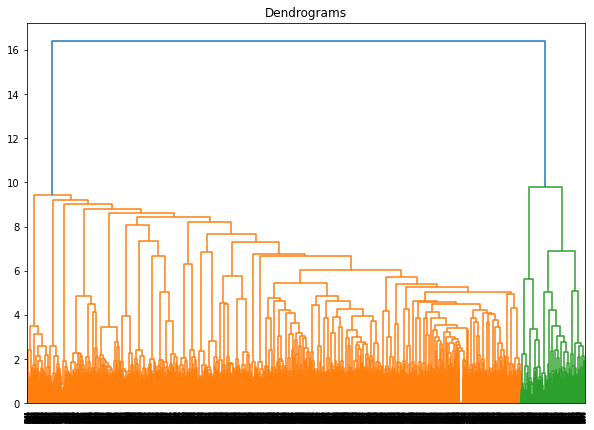

In [30]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(dfr_data, method='ward'))

In [34]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
arr = cluster.fit_predict(dfr_data)

In [35]:
dfr['label'] = arr

In [36]:
dfr.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,ticket,label
0,0.0,0.0,0.0,0.178846,0.0,0.015675,0.033372,0.014330,0.035648,0.017626,...,0.039408,0.000000,0.04249,0.023326,0.000000,0.000000,0.043745,0.0,P10049895-100023,0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.312936,0.000000,0.0,P10049895-100024,1
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.075155,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.101327,0.000000,0.0,P10049895-100237,1
3,0.0,0.0,0.0,0.183928,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.165132,0.00000,0.000000,0.330282,0.000000,0.000000,0.0,P10049895-100313,1
4,0.0,0.0,0.0,0.000000,0.0,0.288407,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.178856,0.0,P10049895-100316,1


In [9]:

save_model(tfidf_trainingset,model_name+".pickle")
save_model(training_ticket_corpus,model_name+"_corpus.pickle")



my_model = load_model(model_name+".pickle")
my_corpus = load_model(model_name+"_corpus.pickle")

tickets_dev_set = corpus[0:5]

for ticket in tickets_dev_set:
    
    document_test = (str(ticket['summary'])+" "+str(ticket['description']))
    cleaned_document = clean_text(document_test)
    cleaned_document = [cleaned_document]
    tfidf_test = tfidf_model.transform(cleaned_document)
    related_indices, related_jiras = find_top_n_similar_documents(6,tfidf_test[0:1],my_model,my_corpus)
    print("\n",ticket['key'],">>>> \n",related_jiras,"\n")

NameError: name 'extract_clean_documents_from_corpus' is not defined